# Deep Bayesian Neural Networks for semi-supervised Representation Learning and Classification

## 1.Introduction

In recent years we witness plenty of breakthroughs powered by probablistic graphical model and deep learning, especially the power of deep generative models such as GAN or VAE. In this project we mainly explore the performances of autoencoder its counterpart: bayesian autorencoder. Besides learning the deep presentation and visualize the result to see whether the representation learned indeed makes sense, we also use the learned representation to perform classification problems. We aim to test whether these deep learning models indeed outperform their probablistic counterpart and whether edward can successfully infer the parameters in the model. The dataset we are using is MNIST, a widely used standard data set for image classification. 

In [46]:
# import all necessary libraries
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import (generator_xy, generator, 
                   load_data, accuracy, visulize,)
import random
import edward as ed
import numpy as np
from AE import encoder, decoder, mlp, NN_classifier
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical, Laplace
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

In [40]:
#A function that would randomly split the training and test set
#Default split proportion 0.8
def split_train_test(DATA, y, proportion=0.8):
    data_size = len(DATA)
    train_size = int(proportion * data_size)
    permutation = [i for i in range(data_size)]
    random.shuffle(permutation)
    train_DATA = DATA[permutation[:train_size]]
    train_label = y[permutation[:train_size]]
    test_DATA = DATA[permutation[train_size:]]
    test_label = y[permutation[train_size:]]
    return train_DATA, train_label, test_DATA, test_label

#Change the one hot representation to label
def categorical(y_one_hot):
    return np.argmax(y_one_hot, axis=1)

## Data

The data we are using are standard MNIST dataset: the data set contains 60,000 training image and testing image, each image is a hand written digit 0~9 (labeled) with size 28 * 28, each pixel being 0 (black) or 1 (white).

In [36]:
ed.set_seed(100)
sess = tf.InteractiveSession()
sess.as_default()
M = 12000
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_AE = load_data('data/encoded_train_AE.pkl')
x_test_AE = load_data('data/encoded_test_AE.pkl')
x_train_BAE = load_data('data/encoded_train_BAE.pkl')
x_test_BAE = load_data('data/encoded_test_BAE.pkl')
x_train_generator = generator_xy([x_train,y_train], M)
x_train_generator_AE = generator_xy([x_train_AE, y_train], M)
x_train_generator_BAE = generator_xy([x_train_BAE, y_train], M)

RuntimeError: Seeding is not supported after initializing part of the graph. Please move set_seed to the beginning of your code.

In [37]:
num_of_class = 10

#### Data Visulization

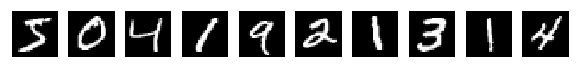

In [3]:
visulize(10, x_train)

## 2.Models 

### Bayesian Autoencoder

Image of the model goes here

### Bayesian Logistics Regression

We will use bayesian logistics regression as a baseline. The parameters are properly tuned, which is made convenient by edward. Particularly, we are interested in the relation of two model criticisms: accuracy, and the difference between prior and posterior parameter distribution.

In [87]:
# Input:
# qz: the distribution of the input variables, either latent/or not dimensions
#y_labels: the labels for this supervised learning
#latent_dim: the dimension of qz
#regression_coef_var: equivalent to regularization term
def bayesian_logistics_regression(qz, y_labels, latent_dim, regression_coef_var, prior, plot_loss=False):
    if prior == 'gaussian':
        regression_coef = Normal(loc=tf.zeros([num_of_class, latent_dim]), 
               scale=regression_coef_var * tf.ones([num_of_class, latent_dim]))
    elif prior == 'laplacian':
        regression_coef = Laplace(loc=tf.zeros([num_of_class, latent_dim]), 
               scale=regression_coef_var * tf.ones([num_of_class, latent_dim]))
    z = tf.placeholder(tf.float32, [qz.shape[0], latent_dim])
    y = Categorical(logits=tf.matmul(z, regression_coef, transpose_b=True))
    qcoeff = Normal(loc=tf.Variable(tf.random_normal([num_of_class, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([num_of_class, latent_dim]))))
    inference = ed.KLqp({regression_coef: qcoeff}, data={z: qz, y: y_labels})
    inference.initialize(n_iter = 1000, n_samples = 5)
    tf.global_variables_initializer().run()        
    losses = []
    for _ in range(100):
        info_dict = inference.update(feed_dict={z: qz, y: y_labels})
        losses.append(info_dict['loss'])
    if plot_loss:
        plt.title('inference loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.plot(range(100), losses)
        plt.show()
    print('finished logistics regression')
    return qcoeff, regression_coef

In [70]:
#A wrapper for raw bayesian logistics regression
#return the area under the roc curve
def raw_bayesian_logistics_regression(regression_coef_var, DATA, labels, prior='gaussian', plot_loss=False):
    train_DATA, train_label, test_DATA, test_label = split_train_test(DATA, labels)
    dimension = DATA.shape[1]
    qcoef, coef_prior = bayesian_logistics_regression(train_DATA, train_label, dimension, regression_coef_var
                                                      , prior, plot_loss)
    n_samples = 100
    test_z = tf.placeholder(tf.float32, test_DATA.shape)
    probas = tf.reduce_mean(tf.stack([tf.sigmoid(tf.matmul(test_z, 
                                                           qcoef.sample(), 
                                                           transpose_b=True)) 
                                      for _ in range(n_samples)],axis=0), axis=0)
    score = probas.eval(feed_dict={test_z: test_DATA})
    y_pred = categorical(score)
    return accuracy_score(y_pred, test_label), qcoef, coef_prior

### Deep Bayesian Neural Network

In [4]:
# define model here
num_hidden = 100
D = 256
num_class = 10

W_0 = Normal(loc = tf.zeros([D, num_hidden]), scale = tf.ones([D, num_hidden]))
W_1 = Normal(loc = tf.zeros([num_hidden, num_class]), scale = tf.ones([num_hidden,num_class]))
b_0 = Normal(loc = tf.zeros(num_hidden), scale = tf.ones(num_hidden))
b_1 = Normal(loc = tf.zeros(num_class), scale = tf.ones(num_class))

x = tf.placeholder(tf.float32, [None, D])

y = Categorical(logits=NN_classifier(x, W_0, W_1, b_0, b_1))


In [5]:
# define the variational model here
qW_0 = Normal(loc = tf.Variable(tf.random_normal([D,num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,num_hidden]))))
qW_1 = Normal(loc = tf.Variable(tf.random_normal([num_hidden,num_class])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden,num_class]))))
qb_0 = Normal(loc = tf.Variable(tf.random_normal([num_hidden])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_hidden]))))
qb_1 = Normal(loc = tf.Variable(tf.random_normal([num_class])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([num_class]))))

## 3.Inference and Critisism

### Baseline: bayesian logistics regression

We try to explore the relation between i)accuracy and ii) whether parameter prior-posterior fit each other. We try to find whether the improvement of parameter prior-posterior fitting would increase the accuracy

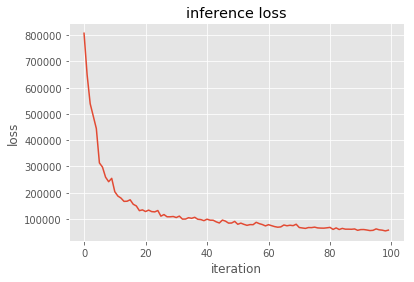

finished logistics regression
The accuracy achieved by raw bayesian logistics regression is 0.789250


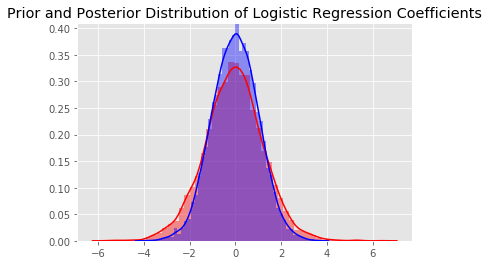

In [88]:
regression_coef_var = 1
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, y_train, plot_loss=True)
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

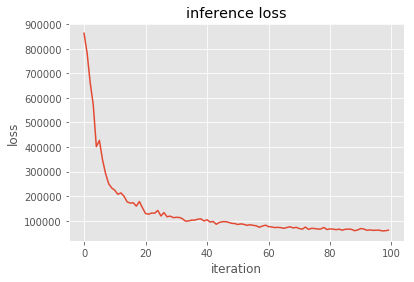

finished logistics regression
The accuracy achieved by raw bayesian logistics regression is 0.816250


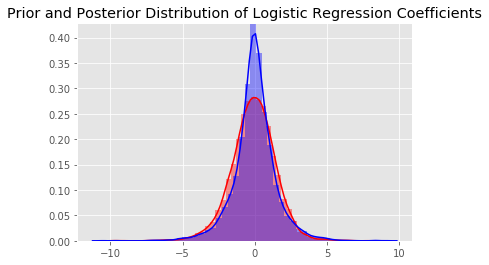

In [89]:
regression_coef_var = 1
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, 
                                                           y_train, prior='laplacian', plot_loss=True)
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

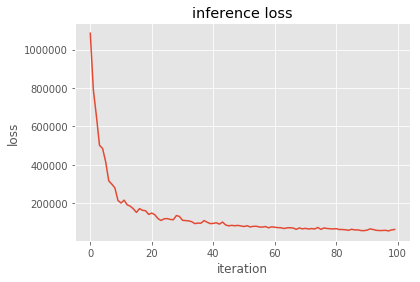

finished logistics regression
The accuracy achieved by raw bayesian logistics regression is 0.856500


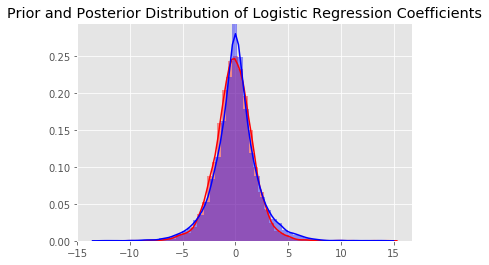

In [90]:
regression_coef_var = 1.5
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, 
                                                           y_train, prior='laplacian', plot_loss=True)
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

### What can we conclude about the previous graphs and statistics? 
First and foremost, there seems to be no problem with the inference algorithm: the loss converges nicely.
However, there seems to be no relation between parameter prior-posterior fitting and accuracy. Is it really the case? In this project we observe that, across different runs, we observe very different performance. Therefore, more runs are necessary to get a stable comparison

In [86]:
cv_fold = 10
result_sheet = np.zeros((3, cv_fold))
for fold in range(cv_fold):
    print('fold = %d' % fold)
    regression_coef_var = 1
    acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, y_train)
    result_sheet[0][fold] = acc
    regression_coef_var = 1
    acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, 
                                                               y_train, prior='laplacian')
    result_sheet[1][fold] = acc
    regression_coef_var = 1.5
    acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, x_train, 
                                                               y_train, prior='laplacian')
    result_sheet[2][fold] = acc

fold = 0
100/100 [100%] ██████████████████████████████ Elapsed: 58s | Loss: 59850.316
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 57s | Loss: 56736.680
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 57s | Loss: 54505.262
finished logistics regression
fold = 1
100/100 [100%] ██████████████████████████████ Elapsed: 52s | Loss: 52947.711
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 54694.570
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 60s | Loss: 57603.133
finished logistics regression
fold = 2
100/100 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 56639.633
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 56s | Loss: 61737.992
finished logistics regression
100/100 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 58407.727
finished logistics regression
fold = 3
1

KeyboardInterrupt: 

In [6]:
# inferece initilization for AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_AE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [7]:
# prior draw and prediction accuracy for AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))


training accuracy:
0.12776666666666667
testing accuracy:
0.1364


In [11]:
n_epoch = 100
n_iter_per_epoch = x_train_AE.shape[0] // M
loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_AE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
    loss.append(-avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1
-log p(x) <= 1.639
Epoch: 2
-log p(x) <= 1.649
Epoch: 3
-log p(x) <= 1.647
Epoch: 4
-log p(x) <= 1.655
Epoch: 5
-log p(x) <= 1.645
Epoch: 6
-log p(x) <= 1.636
Epoch: 7
-log p(x) <= 1.647
Epoch: 8
-log p(x) <= 1.657
Epoch: 9
-log p(x) <= 1.646
Epoch: 10
-log p(x) <= 1.632
Epoch: 11
-log p(x) <= 1.654
Epoch: 12
-log p(x) <= 1.640
Epoch: 13
-log p(x) <= 1.646
Epoch: 14
-log p(x) <= 1.636
Epoch: 15
-log p(x) <= 1.654
Epoch: 16
-log p(x) <= 1.649
Epoch: 17
-log p(x) <= 1.650
Epoch: 18
-log p(x) <= 1.666
Epoch: 19
-log p(x) <= 1.653
Epoch: 20
-log p(x) <= 1.646
Epoch: 21
-log p(x) <= 1.636
Epoch: 22
-log p(x) <= 1.641
Epoch: 23
-log p(x) <= 1.640
Epoch: 24
-log p(x) <= 1.642
Epoch: 25
-log p(x) <= 1.645
Epoch: 26
-log p(x) <= 1.636
Epoch: 27
-log p(x) <= 1.638
Epoch: 28
-log p(x) <= 1.641
Epoch: 29
-log p(x) <= 1.640
Epoch: 30
-log p(x) <= 1.630
Epoch: 31
-log p(x) <= 1.648
Epoch: 32
-log p(x) <= 1.636
Epoch: 33
-log p(x) <= 1.638
Epoch: 34
-log p(x) <= 1.642
Epoch: 35
-log p(x) <= 

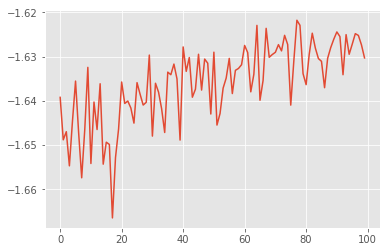

In [13]:
# training loss plot
plt.plot(range(n_epoch), loss)
plt.show()

In [14]:
# posterior accuracy check for AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_AE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_AE, y_test, prior_weights))

training accuracy:
0.9158
testing accuracy:
0.9141


In [15]:
# inferece initilization for Bayesian AE representation
inference = ed.KLqp({W_0:qW_0, b_0:qb_0,
                    W_1:qW_1, b_1:qb_1}, 
                    data = {x: x_train_BAE, y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()

In [16]:
# prior draw and prediction accuracy for Bayesian AE representation
pri_qW_0 = qW_0.sample()
pri_qW_1 = qW_1.sample()
pri_qb_0 = qb_0.sample()
pri_qb_1 = qb_1.sample()

prior_weights = [pri_qW_0, pri_qW_1, pri_qb_0, pri_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))


training accuracy:
0.11296666666666667
testing accuracy:
0.111


In [17]:
n_epoch = 100
n_iter_per_epoch = x_train_BAE.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
    print("Epoch: {0}".format(epoch))
    avg_loss = 0.0

    # pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch + 1):
        # pbar.update(t)
        x_batch, y_batch = next(x_train_generator_BAE)
        info_dict = inference.update(feed_dict={x: x_batch, y: y_batch})
        avg_loss += info_dict['loss']
        avg_loss = avg_loss / n_iter_per_epoch
        avg_loss = avg_loss / M
        log_loss.append(-avg_loss)
    print("-log p(x) <= {:0.3f}".format(avg_loss))

Epoch: 1
-log p(x) <= 2.488
Epoch: 2
-log p(x) <= 2.339
Epoch: 3
-log p(x) <= 2.192
Epoch: 4
-log p(x) <= 2.182
Epoch: 5
-log p(x) <= 2.087
Epoch: 6
-log p(x) <= 2.037
Epoch: 7
-log p(x) <= 1.997
Epoch: 8
-log p(x) <= 1.957
Epoch: 9
-log p(x) <= 1.947
Epoch: 10
-log p(x) <= 1.923
Epoch: 11
-log p(x) <= 1.893
Epoch: 12
-log p(x) <= 1.889
Epoch: 13
-log p(x) <= 1.872
Epoch: 14
-log p(x) <= 1.868
Epoch: 15
-log p(x) <= 1.863
Epoch: 16
-log p(x) <= 1.860
Epoch: 17
-log p(x) <= 1.851
Epoch: 18
-log p(x) <= 1.846
Epoch: 19
-log p(x) <= 1.872
Epoch: 20
-log p(x) <= 1.851
Epoch: 21
-log p(x) <= 1.815
Epoch: 22
-log p(x) <= 1.816
Epoch: 23
-log p(x) <= 1.792
Epoch: 24
-log p(x) <= 1.813
Epoch: 25
-log p(x) <= 1.781
Epoch: 26
-log p(x) <= 1.775
Epoch: 27
-log p(x) <= 1.781
Epoch: 28
-log p(x) <= 1.774
Epoch: 29
-log p(x) <= 1.781
Epoch: 30
-log p(x) <= 1.769
Epoch: 31
-log p(x) <= 1.762
Epoch: 32
-log p(x) <= 1.757
Epoch: 33
-log p(x) <= 1.772
Epoch: 34
-log p(x) <= 1.774
Epoch: 35
-log p(x) <= 

In [18]:
# posterior accuracy check for Bayesian AE representation
pos_qW_0 = qW_0.sample()
pos_qW_1 = qW_1.sample()
pos_qb_0 = qb_0.sample()
pos_qb_1 = qb_1.sample()

posterior_weights = [pos_qW_0, pos_qW_1, pos_qb_0, pos_qb_1] 

print("training accuracy:")
print(accuracy(x_train_BAE, y_train, prior_weights))
print("testing accuracy:")
print(accuracy(x_test_BAE, y_test, prior_weights))

training accuracy:
0.916
testing accuracy:
0.9058


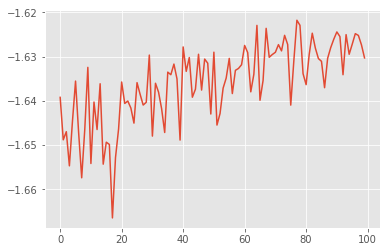

In [19]:
# training loss plot
plt.plot(range(n_epoch), loss)
plt.show()